# MA LSTM
LSTM을 두개 이어붙여 만든 구조.
순환 신경망 기반의 모델

MaLSTM은 맨해튼거리(Manhattan Distance) +  LSTM의 줄임말.

일반적인 문장 유사도를 계산할 때 쓰는 코사인 유사도 대신, 맨해튼 거리를 사용하는 모델


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
DATA_IN_PATH = '/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/quora-question-pairs/'
DATA_OUT_PATH =  '/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/quora-question-pairs/out/'
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [ ]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [ ]:
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [ ]:
model_name = 'malstm_similarity'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1

kargs = {
    'vocab_size': prepro_configs['vocab_size'],
    'embedding_dimension': 100,
    'lstm_dimension': 150,
}

In [ ]:
# 모델 생성
class MaLSTM(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(MaLSTM, self).__init__(name=model_name)
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm = layers.LSTM(units=kargs['lstm_dimension'])
        
    def call(self, x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.lstm(x1)
        x2 = self.lstm(x2)
        x = tf.exp(-tf.reduce_sum(tf.abs(x1 - x2), axis=1))
        
        return x

In [ ]:
model = MaLSTM(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/quora-question-pairs/out/malstm_similarity -- Folder create complete 



In [ ]:
history = model.fit((q1_data, q2_data), labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
2100/2100 [==============================] - 695s 329ms/step - loss: 0.6099 - accuracy: 0.6842 - val_loss: 0.7548 - val_accuracy: 0.5983

Epoch 00001: val_accuracy improved from -inf to 0.59829, saving model to /content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/quora-question-pairs/out/malstm_similarity/weights.h5
Epoch 2/5
2100/2100 [==============================] - 689s 328ms/step - loss: 0.4094 - accuracy: 0.8158 - val_loss: 0.5109 - val_accuracy: 0.7730

Epoch 00002: val_accuracy improved from 0.59829 to 0.77300, saving model to /content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/quora-question-pairs/out/malstm_similarity/weights.h5
Epoch 3/5
2100/2100 [==============================] - 684s 325ms/step - loss: 0.3499 - accuracy: 0.8498 - val_loss: 0.5068 - val_accuracy: 0.7870

Epoch 00003: val_accuracy improved from 0.77300 to 0.78695, saving model to /content/drive/MyDrive/20

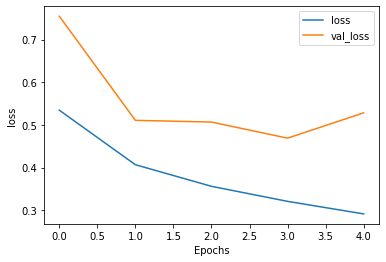

In [ ]:
plot_graphs(history, 'loss')

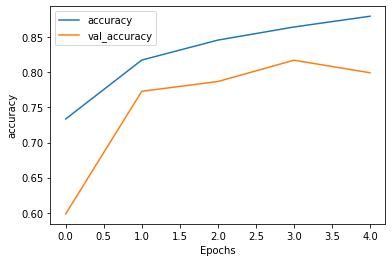

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [ ]:
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [ ]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)

In [ ]:
# 결과 저장 후 Kaggle에 업로드
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv(DATA_OUT_PATH+"rnn_predict.csv", index=False, quoting=3)